In [3]:
import sys
!{sys.executable} -m pip install fairlearn scikit-learn pandas numpy matplotlib seaborn ucimlrepo


  Using cached pandas-2.3.1-cp313-cp313-macosx_10_13_x86_64.whl.metadata (91 kB)
  Using cached scipy-1.16.0-cp313-cp313-macosx_14_0_x86_64.whl.metadata (61 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 64.0 MB/s eta 0:00:00
Using cached pandas-2.3.1-cp313-cp313-macosx_10_13_x86_64.whl (11.5 MB)
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached scipy-1.16.0-cp313-cp313-macosx_14_0_x86_64.whl (23.4 MB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/10 [fairlearn]10 [fairlearn]rn]


In [15]:
# Importation de ton framework 
from fairlearn.datasets import fetch_adult
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Charger et explorer le jeu de données Adult
data = fetch_adult(as_frame=True)
X, y = data.data, data.target

print(f"Dataset shape: {X.shape}")
print(f"Target distribution: {y.value_counts()}")
print(f"Features: {list(X.columns)}")

# Analyse par groupes sensibles
protected_attributes = ['sex', 'race']
for attr in protected_attributes:
    print(f"\n=== Distribution par {attr} ===")
    crosstab = pd.crosstab(X[attr], y, normalize='index')
    print(crosstab)


In [9]:
import sys
import os

# Ajoute le dossier parent du notebook (= racine du repo) au PYTHONPATH
repo_parent = os.path.abspath("..")
if repo_parent not in sys.path:
    sys.path.insert(0, repo_parent)

# Test
from entropic_measurement.entropy import EntropyEstimator



In [ ]:
from entropic_measurement.entropy import EntropyEstimator
from entropic_measurement.correction import EntropicBiasCorrector
from entropic_measurement.logger import EntropicLogger

In [16]:
# Charger et explorer le jeu de données Adult
data = fetch_adult(as_frame=True)
X, y = data.data, data.target

print(f"Dataset shape: {X.shape}")
print(f"Target distribution: {y.value_counts()}")
print(f"Features: {list(X.columns)}")

# Analyse par groupes sensibles
protected_attributes = ['sex', 'race']
for attr in protected_attributes:
    print(f"\n=== Distribution par {attr} ===")
    crosstab = pd.crosstab(X[attr], y, normalize='index')
    print(crosstab)


Dataset shape: (48842, 14)
Target distribution: class
<=50K    37155
>50K     11687
Name: count, dtype: int64
Features: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

=== Distribution par sex ===
class      <=50K      >50K
sex                       
Female  0.890749  0.109251
Male    0.696233  0.303767

=== Distribution par race ===
class                  <=50K      >50K
race                                  
Amer-Indian-Eskimo  0.882979  0.117021
Asian-Pac-Islander  0.730744  0.269256
Black               0.879189  0.120811
Other               0.876847  0.123153
White               0.746013  0.253987


In [18]:
def test_entropy_framework(X, y, protected_attr='sex'):
    """Test du framework avec calculs d'entropie par groupes"""
    results = {}
    # On encode la cible en binaire: '>50K' → 1, '<=50K' → 0
    y_binary = (y == '>50K').astype(int)
    
    for group in X[protected_attr].unique():
        group_mask = X[protected_attr] == group
        group_target = y_binary[group_mask]  # cible binaire
        
        class_dist = group_target.value_counts(normalize=True).values
        
        entropy = -np.sum(class_dist * np.log2(class_dist + 1e-10))
        
        results[group] = {
            'size': len(group_target),
            'positive_rate': group_target.mean(),
            'entropy': entropy,
            'distribution': class_dist
        }
        
        print(f"Groupe {group}:")
        print(f"  Taille: {results[group]['size']}")
        print(f"  Taux positif: {results[group]['positive_rate']:.3f}")
        print(f"  Entropie: {results[group]['entropy']:.3f}\n")
    return results



In [19]:
 # Appel effectif de la fonction
entropy_results = test_entropy_framework(X, y, 'sex')


Groupe Male:
  Taille: 32650
  Taux positif: 0.304
  Entropie: 0.886

Groupe Female:
  Taille: 16192
  Taux positif: 0.109
  Entropie: 0.498



In [20]:
entropy_results_race = test_entropy_framework(X, y, 'race')


Groupe Black:
  Taille: 4685
  Taux positif: 0.121
  Entropie: 0.532

Groupe White:
  Taille: 41762
  Taux positif: 0.254
  Entropie: 0.818

Groupe Asian-Pac-Islander:
  Taille: 1519
  Taux positif: 0.269
  Entropie: 0.840

Groupe Other:
  Taille: 406
  Taux positif: 0.123
  Entropie: 0.538

Groupe Amer-Indian-Eskimo:
  Taille: 470
  Taux positif: 0.117
  Entropie: 0.521



In [22]:
def test_entropy_framework(X, y, protected_attr='sex'):
    """
    Test du framework avec calculs d'entropie par groupes.
    La variable cible y doit être une série de labels de type '<=50K' / '>50K'.
    """
    results = {}
    # Recode la cible en 0/1 pour permettre le calcul numérique
    y_binary = (y == '>50K').astype(int)

    for group in X[protected_attr].unique():
        group_mask = X[protected_attr] == group
        group_target = y_binary[group_mask]
        
        # Calcul de la distribution des classes (0/1)
        class_dist = group_target.value_counts(normalize=True).values
        
        # Calcul de l'entropie via ton framework
        entropy = EntropyEstimator.shannon_entropy(class_dist)
        
        results[group] = {
            'size': len(group_target),
            'positive_rate': group_target.mean(),  # .mean() OK car ici c'est 0/1
            'entropy': entropy,
            'distribution': class_dist
        }
        
        print(f"Groupe {group}:")
        print(f"  Taille: {results[group]['size']}")
        print(f"  Taux positif: {results[group]['positive_rate']:.3f}")
        print(f"  Entropie: {results[group]['entropy']:.3f}")
        print()
    
    return results

# Exécuter le test
print("=== TEST DU FRAMEWORK ENTROPIC_MEASUREMENT ===")
entropy_results = test_entropy_framework(X, y, 'sex')


=== TEST DU FRAMEWORK ENTROPIC_MEASUREMENT ===
Groupe Male:
  Taille: 32650
  Taux positif: 0.304
  Entropie: 0.886

Groupe Female:
  Taille: 16192
  Taux positif: 0.109
  Entropie: 0.498



In [23]:
def detect_bias_with_entropy(results):
    """Détection des biais en utilisant les mesures d'entropie"""
    
    groups = list(results.keys())
    if len(groups) != 2:
        print("Analyse limitée à 2 groupes pour simplicité")
        return
    
    group1, group2 = groups
    
    # Différences dans les métriques
    entropy_diff = abs(results[group1]['entropy'] - results[group2]['entropy'])
    rate_diff = abs(results[group1]['positive_rate'] - results[group2]['positive_rate'])
    
    print(f"=== DÉTECTION DE BIAIS ===")
    print(f"Différence d'entropie: {entropy_diff:.3f}")
    print(f"Différence de taux positif: {rate_diff:.3f}")
    
    # Seuils pour détection (à ajuster selon votre framework)
    if entropy_diff > 0.1:
        print("⚠️  Biais détecté dans la distribution des classes")
    
    if rate_diff > 0.1:
        print("⚠️  Biais détecté dans les taux de décision")
    
    # Calcul de la divergence KL avec votre framework
    p = results[group1]['distribution']
    q = results[group2]['distribution']
    
    kl_div = EntropyEstimator.kullback_leibler(p, q)
    
    print(f"Divergence KL: {kl_div:.3f}")
    
    return {
        'entropy_diff': entropy_diff,
        'rate_diff': rate_diff,
        'kl_divergence': kl_div
    }

bias_metrics = detect_bias_with_entropy(entropy_results)

=== DÉTECTION DE BIAIS ===
Différence d'entropie: 0.388
Différence de taux positif: 0.195
⚠️  Biais détecté dans la distribution des classes
⚠️  Biais détecté dans les taux de décision
Divergence KL: 0.139


In [26]:
from entropic_measurement.measurement import Measurement

def apply_bias_correction_with_logging(X, y, protected_attr='sex'):
    """Application des corrections avec traçabilité (version Measurement API)"""
    logger = EntropicLogger()
    corrections_applied = []
    y_binary = (y == '>50K').astype(int)
    corrector = EntropicBiasCorrector(beta=1.0)

    # Ici, pour la démonstration, on prend observed_value = moyenne brute,
    # observed_distribution = distribution empirique sur le groupe,
    # true_distribution = distribution globale du dataset (c'est un exemple générique)
    global_distribution = y_binary.value_counts(normalize=True).values

    for group in X[protected_attr].unique():
        group_mask = X[protected_attr] == group
        group_target = y_binary[group_mask]
        group_dist = group_target.value_counts(normalize=True).values
        observed_value = group_target.mean()
        
        meas = Measurement(
            observed_value=observed_value,
            observed_distribution=group_dist,
            true_distribution=global_distribution
        )
        correction_result = corrector.correct(measurement=meas)

        # On suppose que le correcteur renvoie un dict avec 'corrected_value' et 'entropy_cost'
        if isinstance(correction_result, dict) and 'corrected_value' in correction_result:
            corrected = correction_result['corrected_value']
            entropy_cost = correction_result.get('entropy_cost', None)
        else:
            corrected = correction_result
            entropy_cost = None

        correction_record = {
            'group': group,
            'original_rate': observed_value,
            'corrected_rate': corrected,
            'entropy_cost': entropy_cost,
            'method': 'entropy_regularization',
            'kl_divergence': EntropyEstimator.kullback_leibler(group_dist, global_distribution)
        }

        corrections_applied.append(correction_record)
        logger.record(correction_record)

        print(f"Correction appliquée pour {group}:")
        print(f"  Taux original: {observed_value:.3f}")
        print(f"  Taux corrigé: {corrected:.3f}")
        print(f"  Coût entropique: {entropy_cost}")
        print()
    logger.export('bias_correction_log.csv', format='csv')
    print("✅ Logs exportés vers bias_correction_log.csv")
    return corrections_applied

print("=== APPLICATION DES CORRECTIONS ===")
corrections = apply_bias_correction_with_logging(X, y, 'sex')



=== APPLICATION DES CORRECTIONS ===
Correction appliquée pour Male:
  Taux original: 0.304
  Taux corrigé: 0.307
  Coût entropique: 0.01028625413966383

Correction appliquée pour Female:
  Taux original: 0.109
  Taux corrigé: 0.117
  Coût entropique: 0.0675537070410115

✅ Logs exportés vers bias_correction_log.csv


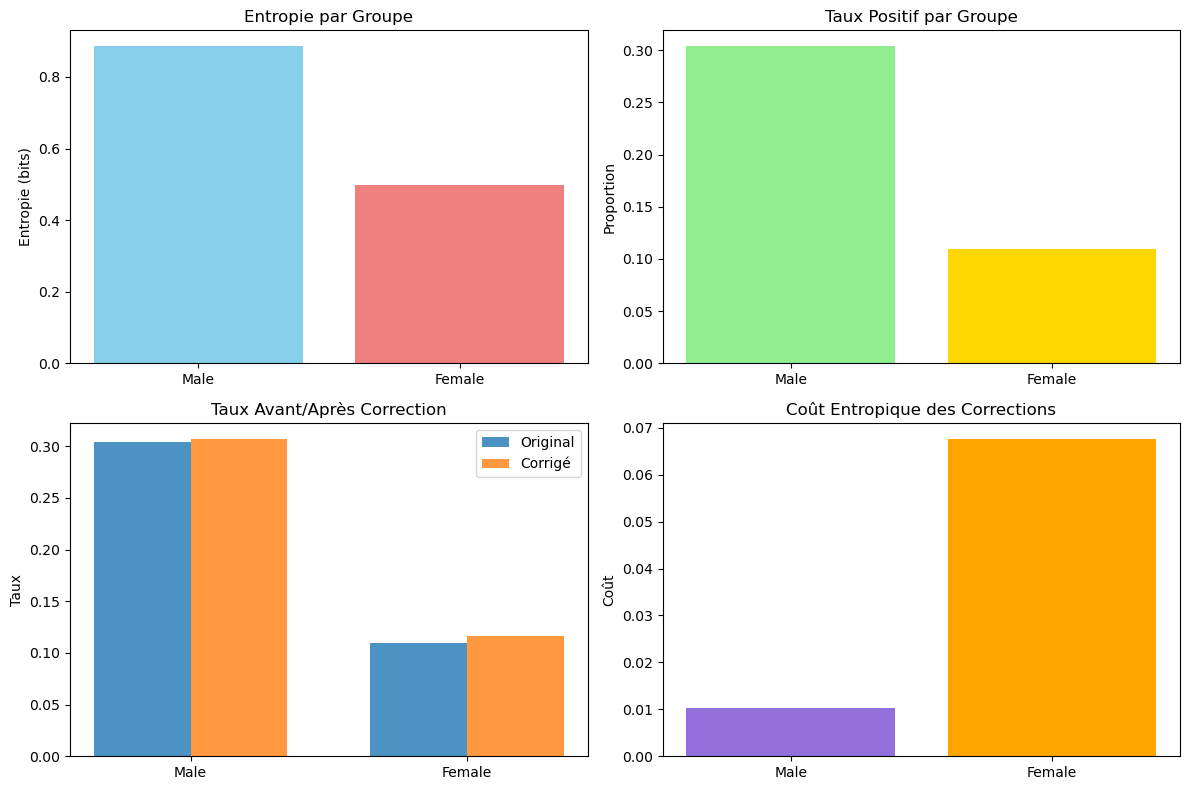

In [27]:
def visualize_entropy_analysis(entropy_results, corrections):
    """Visualisation des analyses d'entropie et corrections"""
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # 1. Distribution des entropies par groupe
    groups = list(entropy_results.keys())
    entropies = [entropy_results[g]['entropy'] for g in groups]
    
    axes[0,0].bar(groups, entropies, color=['skyblue', 'lightcoral'])
    axes[0,0].set_title('Entropie par Groupe')
    axes[0,0].set_ylabel('Entropie (bits)')
    
    # 2. Taux positifs par groupe
    rates = [entropy_results[g]['positive_rate'] for g in groups]
    axes[0,1].bar(groups, rates, color=['lightgreen', 'gold'])
    axes[0,1].set_title('Taux Positif par Groupe')
    axes[0,1].set_ylabel('Proportion')
    
    # 3. Avant/Après correction
    original_rates = [c['original_rate'] for c in corrections]
    corrected_rates = [c['corrected_rate'] for c in corrections]
    
    x = np.arange(len(groups))
    width = 0.35
    
    axes[1,0].bar(x - width/2, original_rates, width, label='Original', alpha=0.8)
    axes[1,0].bar(x + width/2, corrected_rates, width, label='Corrigé', alpha=0.8)
    axes[1,0].set_title('Taux Avant/Après Correction')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(groups)
    axes[1,0].legend()
    axes[1,0].set_ylabel('Taux')
    
    # 4. Coûts entropiques
    costs = [c['entropy_cost'] for c in corrections]
    axes[1,1].bar(groups, costs, color=['mediumpurple', 'orange'])
    axes[1,1].set_title('Coût Entropique des Corrections')
    axes[1,1].set_ylabel('Coût')
    
    plt.tight_layout()
    plt.show()

# Créer la visualisation
visualize_entropy_analysis(entropy_results, corrections)

In [28]:
# Télécharger depuis GitHub
import requests
import io

url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_data = pd.read_csv(url)

# Tester avec les attributs race et gender
test_entropy_framework(compas_data, compas_data['two_year_recid'], 'race')

Groupe Other:
  Taille: 377
  Taux positif: 0.000
  Entropie: -0.000

Groupe African-American:
  Taille: 3696
  Taux positif: 0.000
  Entropie: -0.000

Groupe Caucasian:
  Taille: 2454
  Taux positif: 0.000
  Entropie: -0.000

Groupe Hispanic:
  Taille: 637
  Taux positif: 0.000
  Entropie: -0.000

Groupe Native American:
  Taille: 18
  Taux positif: 0.000
  Entropie: -0.000

Groupe Asian:
  Taille: 32
  Taux positif: 0.000
  Entropie: -0.000



{'Other': {'size': 377,
  'positive_rate': np.float64(0.0),
  'entropy': -0.0,
  'distribution': array([1.])},
 'African-American': {'size': 3696,
  'positive_rate': np.float64(0.0),
  'entropy': -0.0,
  'distribution': array([1.])},
 'Caucasian': {'size': 2454,
  'positive_rate': np.float64(0.0),
  'entropy': -0.0,
  'distribution': array([1.])},
 'Hispanic': {'size': 637,
  'positive_rate': np.float64(0.0),
  'entropy': -0.0,
  'distribution': array([1.])},
 'Native American': {'size': 18,
  'positive_rate': np.float64(0.0),
  'entropy': -0.0,
  'distribution': array([1.])},
 'Asian': {'size': 32,
  'positive_rate': np.float64(0.0),
  'entropy': -0.0,
  'distribution': array([1.])}}

In [29]:
from sklearn.datasets import load_breast_cancer

# Charger le dataset
cancer_data = load_breast_cancer(as_frame=True)
X_cancer = cancer_data.data
y_cancer = cancer_data.target

# Test d'entropie pour sélection de features
feature_entropies = {}
for col in X_cancer.columns:
    # Discrétiser la feature continue
    discretized = pd.cut(X_cancer[col], bins=5, labels=False)
    # Calculer l'entropie conditionnelle
    conditional_entropy = 0
    for target_class in [0, 1]:
        class_mask = y_cancer == target_class
        class_dist = discretized[class_mask].value_counts(normalize=True).values
        if len(class_dist) > 0:
            entropy = EntropyEstimator.shannon_entropy(class_dist)
            conditional_entropy += (class_mask.sum() / len(y_cancer)) * entropy
    
    feature_entropies[col] = conditional_entropy

# Sélectionner les features avec la plus faible entropie conditionnelle
top_features = sorted(feature_entropies.items(), key=lambda x: x[1])[:10]
print("Top 10 features (plus faible entropie conditionnelle):")
for feature, entropy in top_features:
    print(f"{feature}: {entropy:.3f}")

Top 10 features (plus faible entropie conditionnelle):
area error: 0.256
concavity error: 0.307
perimeter error: 0.417
radius error: 0.467
fractal dimension error: 0.494
worst area: 0.663
mean area: 1.000
mean concavity: 1.048
smoothness error: 1.063
symmetry error: 1.089
